# Notebook to create Upset plot

**Created by** : **Srivalli Kolla**

**Devloped on** : July 23,2024 

**Last Modified** : September 1,2024 

**Institute of Systems Immunology, University of Wurzburg**

# Importing packages

In [7]:
import os
import datetime
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import upsetplot
from scipy import sparse
import matplotlib.pyplot as plt
from upsetplot import UpSet
from upsetplot import from_memberships, UpSet, from_contents
import matplotlib.pyplot as plt

In [8]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

timestamp = datetime.datetime.now().strftime("%d_%m_%y")

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 8.2.0
argcomplete         NA
backcall            0.2.0
backports_abc       NA
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
cloudpickle         2.2.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.9.0
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
fsspec              2023.1.0
h5py                3.7.0
ipykernel           6.16.2
ipython_genutils    0.2.0
jedi                0.19.1
jinja2              3.1.4
joblib              1.3.2
kiwisolver          1.4.4
llvmlite            0.39.1
markupsafe          2.1.5
matplotlib          3.5.3
matplotlib_inline   0.1.7
more_itertools      NA
mpl_toolkits        NA
natsort             8.4.0
nbinom_ufunc        NA
numba               0.56.3
numpy               1.21.6
packaging           23.2
pandas              1.3.5
parso               0.8.4
pex

In [9]:
file_paths = [
    ('../de_results/DE_mdx_cell_statesvCM2_01_09_24.txt', 'Mdx'),
    ('../de_results/DE_mdx_cell_statesvCM3_01_09_24.txt', 'Mdx'),
    ('../de_results/DE_mdx_cell_statesvCM4_01_09_24.txt', 'Mdx'),
    ('../de_results/DE_mdxscid_cell_statesvCM2_01_09_24.txt', 'Mdxscid'),
    ('../de_results/DE_mdxscid_cell_statesvCM3_01_09_24.txt', 'Mdxscid'),
    ('../de_results/DE_mdxscid_cell_statesvCM4_01_09_24.txt', 'Mdxscid'),
    ('../de_results/DE_wt_cell_statesvCM2_01_09_24.txt', 'Wt'),
    ('../de_results/DE_wt_cell_statesvCM3_01_09_24.txt', 'Wt'),
    ('../de_results/DE_wt_cell_statesvCM4_01_09_24.txt', 'Wt'),
]

In [10]:
def read_and_add_info(file_path, genotype):
    df = pd.read_csv(file_path, sep='\t')
    try:
        df['cell_states'] = df['cell_states'].str.extract(r'v(CM\d+)')
        print(f"Extracted cell states: {df['cell_states'].unique()} from file: {file_path}")
    except Exception as e:
        print(f"Error extracting cell states from file {file_path}: {e}")
    df['genotype'] = genotype
    return df

all_data = pd.concat([read_and_add_info(file, genotype) for file, genotype in file_paths])

output_path = f'../de_results/concat_de_results_{timestamp}.csv'
all_data.to_csv(output_path, index=False)
print(f"All data written to {output_path}")


Extracted cell states: ['CM2'] from file: ../de_results/DE_mdx_cell_statesvCM2_01_09_24.txt
Extracted cell states: ['CM3'] from file: ../de_results/DE_mdx_cell_statesvCM3_01_09_24.txt
Extracted cell states: ['CM4'] from file: ../de_results/DE_mdx_cell_statesvCM4_01_09_24.txt
Extracted cell states: ['CM2'] from file: ../de_results/DE_mdxscid_cell_statesvCM2_01_09_24.txt
Extracted cell states: ['CM3'] from file: ../de_results/DE_mdxscid_cell_statesvCM3_01_09_24.txt
Extracted cell states: ['CM4'] from file: ../de_results/DE_mdxscid_cell_statesvCM4_01_09_24.txt
Extracted cell states: ['CM2'] from file: ../de_results/DE_wt_cell_statesvCM2_01_09_24.txt
Extracted cell states: ['CM3'] from file: ../de_results/DE_wt_cell_statesvCM3_01_09_24.txt
Extracted cell states: ['CM4'] from file: ../de_results/DE_wt_cell_statesvCM4_01_09_24.txt
All data written to ../de_results/concat_de_results_01_09_24.csv


In [11]:
filtered_data = all_data[(all_data['p_value'] < 0.01) & 
                          ((all_data['log_fold_change'] < -1.0) | (all_data['log_fold_change'] > 1.0))]

gene_sets = {}
for cell_state in filtered_data['cell_states'].unique():
    gene_sets[cell_state] = set(filtered_data[filtered_data['cell_states'] == cell_state]['gene_id'])

memberships = []
for gene in filtered_data['gene_id'].unique():
    gene_membership = frozenset(cell_state for cell_state, genes in gene_sets.items() if gene in genes)
    if gene_membership:  
        memberships.append(gene_membership)

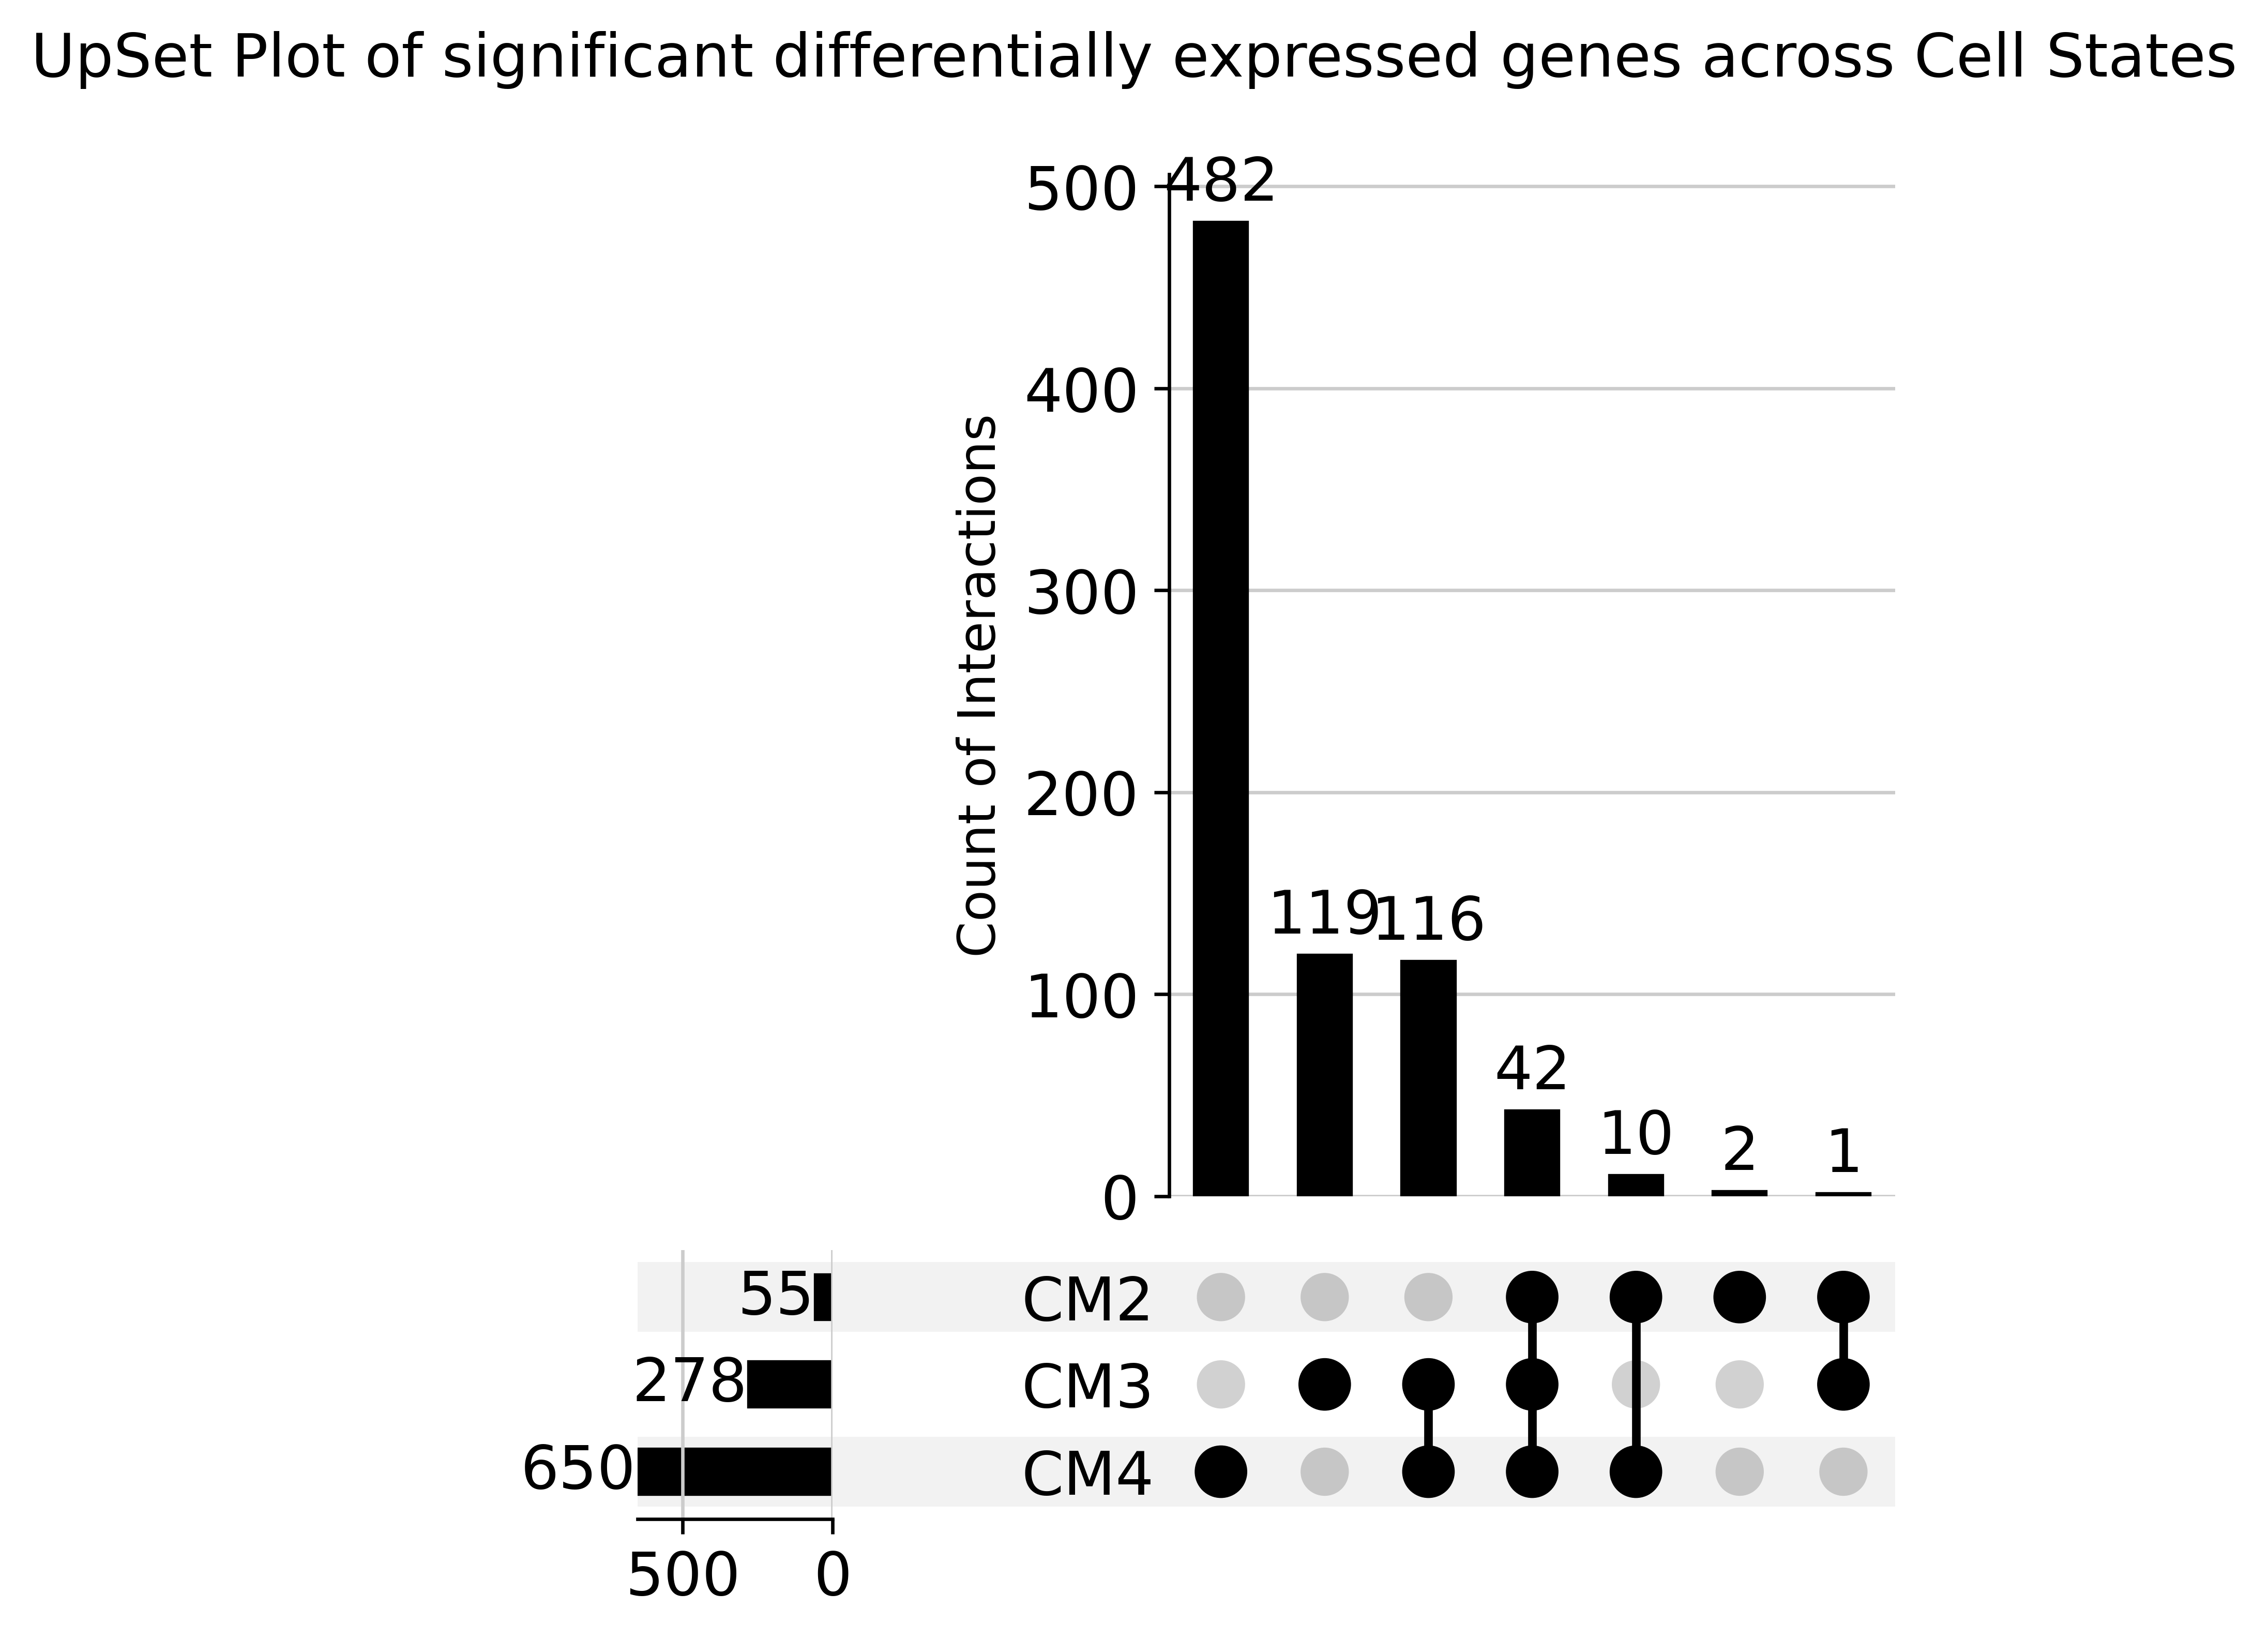

<Figure size 1200x1200 with 0 Axes>

In [12]:
upset_data = from_memberships(memberships)
fig = plt.figure(figsize=(12, 8))
upset = UpSet(upset_data, 
              subset_size='count', 
              show_counts=True, 
              sort_by='cardinality',
              min_subset_size=1,  
              intersection_plot_elements=10)  

upset.plot(fig=fig)

plt.suptitle('UpSet Plot of significant differentially expressed genes across Cell States', fontsize=14)
plt.xlabel('Intersections', fontsize=12)
plt.ylabel('Count of Interactions', fontsize=12)
plt.yticks(rotation=0, ha='right')
plt.subplots_adjust(top=0.90, left=0.2)  
plt.show()
plt.savefig(f'../de_results/upset_plot_cell_states_{timestamp}.png')

In [13]:
filtered_data = all_data[(all_data['p_value'] < 0.01) & 
                         ((all_data['log_fold_change'] < -1.0) | (all_data['log_fold_change'] > 1.0))]

gene_sets = {}
for genotype in filtered_data['genotype'].unique():
    gene_sets[genotype] = set(filtered_data[filtered_data['genotype'] == genotype]['gene_id'])

memberships = []
for gene in filtered_data['gene_id'].unique():
    gene_membership = frozenset(genotype for genotype, genes in gene_sets.items() if gene in genes)
    if gene_membership:  
        memberships.append(gene_membership)

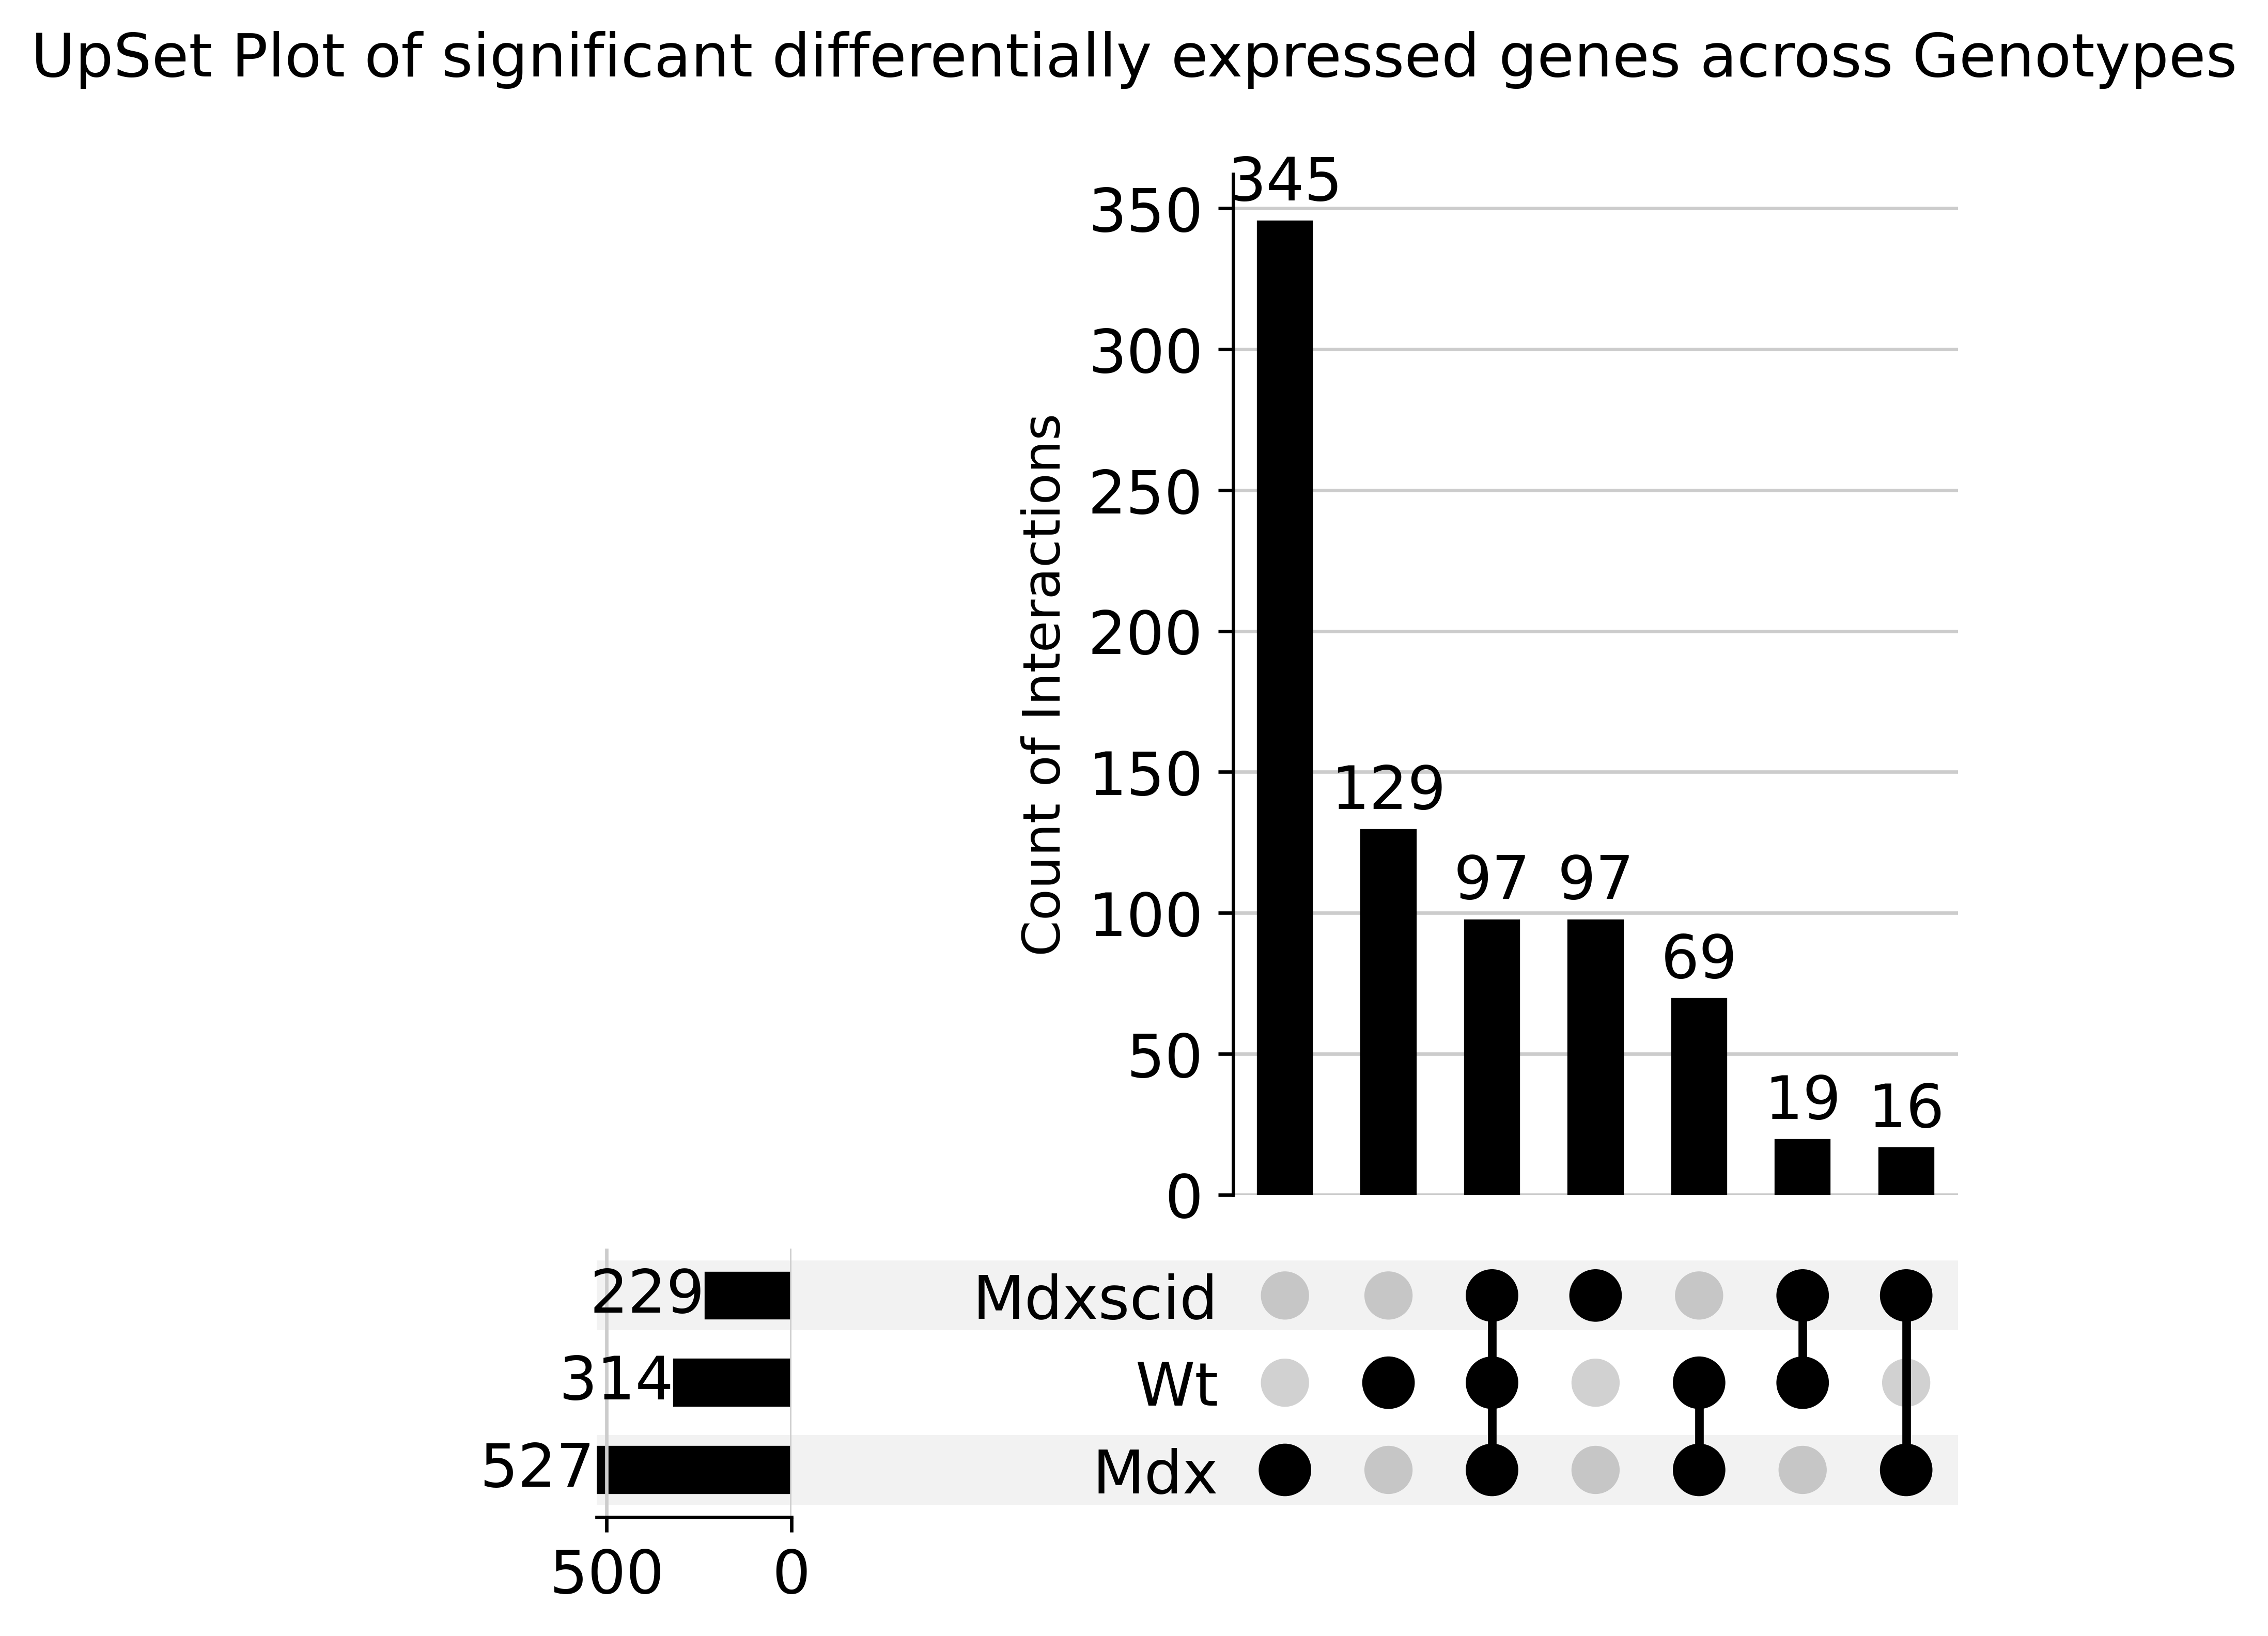

<Figure size 1200x1200 with 0 Axes>

In [14]:
upset_data = from_memberships(memberships)
fig = plt.figure(figsize=(12, 8))
upset = UpSet(upset_data, 
              subset_size='count', 
              show_counts=True, 
              sort_by='cardinality',
              min_subset_size=1,  
              intersection_plot_elements=10)  

upset.plot(fig=fig)

plt.suptitle('UpSet Plot of significant differentially expressed genes across Genotypes', fontsize=14)
plt.xlabel('Intersections', fontsize=12)
plt.ylabel('Count of Interactions', fontsize=12)
plt.yticks(rotation=0, ha='right')
plt.subplots_adjust(top=0.90, left=0.2) 
plt.show()
plt.savefig(f'../de_results/upset_plot_genotype_{timestamp}.png')